In [126]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gpflow as gpf
from gpflow.ci_utils import reduce_in_tests
from gpflow.utilities import print_summary
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tensorflow as tf

gpf.config.set_default_float(np.float64)
gpf.config.set_default_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline

MAXITER = reduce_in_tests(2000)

In [127]:
X_df=None
X_domain_info=None
y_df=None
with open('X_df.pkl', 'rb') as f:
    X_df = pickle.load(f)
with open('X_domain_info.pkl', 'rb') as f:
    X_domain_info = pickle.load(f)
with open('y_df.pkl', 'rb') as f:
    y_df = pickle.load(f)

df = pd.read_csv('GDSC1_melanoma_BRAF_5conc_noreps_v3.csv')
X_df = df[['ARID1A_mut', 'ARID2_mut', 'BRAF_mut', 'CDKN2A_mut',
       'EZH2_mut', 'MECOM_mut', 'NF1_mut', 'NRAS_mut', 'PLCB1_mut', 'PTEN_mut',
       'TP53_mut', 'loss.cnaSKCM3', 'loss.cnaSKCM4..BNC2.CDKN2A.JAK2.PSIP1.',
       'loss.cnaSKCM5..PAX5.', 'loss.cnaSKCM9', 'gain.cnaSKCM12..KRAS.',
       'gain.cnaSKCM21..FOXP1.MITF.', 'loss.cnaSKCM22', 'loss.cnaSKCM23',
       'loss.cnaSKCM24..loss.cnaSKCM25', 'loss.cnaSKCM26',
       'loss.cnaSKCM27..CASP1.', 'loss.cnaSKCM28', 'loss.cnaSKCM30']]
y_df = df[['norm_cells_1', 'norm_cells_2', 'norm_cells_3',
       'norm_cells_4', 'norm_cells_5']]


num_conc=y_df.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.1, random_state=42)


X_train = np.array(X_train, dtype=np.float64)
y_train = np.array(y_train, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [128]:

mask_bool_met = X_df.columns.str.contains("HypMET")
mask_bool_mut = X_df.columns.str.contains("mut")
mask_bool_cna = X_df.columns.str.contains("cna")
mask_bool_dc  = X_df.columns.str.contains("dc")

mask_float_met = np.array(mask_bool_met, dtype=np.float64) 
mask_float_mut = np.array(mask_bool_mut, dtype=np.float64)
mask_float_cna = np.array(mask_bool_cna, dtype=np.float64)
mask_float_dc  = np.array(mask_bool_dc, dtype=np.float64)

diag_matrix_met = np.diag(mask_float_met)
diag_matrix_mut = np.diag(mask_float_mut)
diag_matrix_cna = np.diag(mask_float_cna)
diag_matrix_dc  = np.diag(mask_float_dc)
filters=(diag_matrix_mut,diag_matrix_met,diag_matrix_cna,diag_matrix_dc)
print("MUT features:"+str(np.sum(mask_float_mut)))
print("Met features:"+str(np.sum(mask_float_met)))
print("CNA features:"+str(np.sum(mask_float_cna)))
print("DC features:"+str(np.sum(mask_float_dc)))

MUT features:11.0
Met features:0.0
CNA features:13.0
DC features:0.0


In [129]:
N = X_train.shape[0]  # number of points
D = X_train.shape[1]  # number of input dimensions
M = 14  # number of inducing points
L = 5 # number of latent GPs
P = y_train.shape[1]  # number of observations = output dimensions

# N = 100  # number of points
# D = 1  # number of input dimensions
# M = 15  # number of inducing points
# L = 2  # number of latent GPs
# P = 3  # number of observations = output dimensions

print("number of points: {}".format(N))
print("number of input dimensions: {}".format(D))
print("number of inducing points: {}".format(M))
print("number of latent GPs: {}".format(L))
print("number of observations = output dimensions: {}".format(P))

number of points: 72
number of input dimensions: 24
number of inducing points: 14
number of latent GPs: 5
number of observations = output dimensions: 5


In [130]:
X, Y = data =X_train,y_train


def select_kmeans_inducing_points(X, M):
    # 使用 k-means 聚类找到 M 个中心点
    kmeans = KMeans(n_clusters=M, random_state=0).fit(X)
    return kmeans.cluster_centers_

# 使用示例
Zinit = select_kmeans_inducing_points(X, M)


c:\Users\25858\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [131]:
# def generate_data(N=100):
#     X = np.random.rand(N)[:, None] * 10 - 5  # Inputs = N x D
#     G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))  # G = N x L
#     W = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])  # L x P
#     F = np.matmul(G, W)  # N x P
#     Y = F + np.random.randn(*F.shape) * [0.2, 0.2, 0.2]

#     return X, Y

# X, Y = data = generate_data(N)
# Zinit = np.linspace(-5, 5, M)[:, None]

In [132]:
class QuadripleRBFKernel(gpf.kernels.Kernel):
    def __init__(self, lc_mut=1.0, lc_met=1.0, lc_cna=1.0, variance=1.0, **kwargs):
        super().__init__(**kwargs)
        self.lc_mut = gpf.Parameter(lc_mut)
        self.lc_met = gpf.Parameter(lc_met)
        self.lc_cna = gpf.Parameter(lc_cna)
        self.variance = gpf.Parameter(variance)

        # Define the diagonal matrices as parameters
        self.diag_matrix_mut = diag_matrix_mut  
        self.diag_matrix_met = diag_matrix_met 
        self.diag_matrix_cna = diag_matrix_cna 

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        
        # Compute the kernel matrix with the parameters
        X = tf.matmul(X, self.diag_matrix_mut / self.lc_mut + self.diag_matrix_met / self.lc_met + self.diag_matrix_cna / self.lc_cna)
        X2 = tf.matmul(X2, self.diag_matrix_mut / self.lc_mut + self.diag_matrix_met / self.lc_met + self.diag_matrix_cna / self.lc_cna)
        sqdist = tf.reduce_sum(tf.square(X[:, None, :] - X2[None, :, :]), axis=-1)
        return self.variance * tf.exp(-0.5 * sqdist)

    def K_diag(self, X):
        return tf.fill([tf.shape(X)[0]], self.variance)


In [133]:
def plot_model(m, lower=-8.0, upper=8.0):
    pX = np.linspace(lower, upper, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(X, Y, "x")
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("f")
    plt.title(f"ELBO: {m.elbo(data):.3}")
    plt.plot(Z, Z * 0.0, "o")

In [134]:
def optimize_model_with_scipy(model):
    optimizer = gpf.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss_closure(data),
        variables=model.trainable_variables,
        options={"maxiter": MAXITER},
    )


In [135]:
# Create list of kernels for each output
kern_list = [
    # gpf.kernels.SquaredExponential() + gpf.kernels.Linear() for _ in range(L)
    gpf.kernels.Linear()  for _ in range(L)
]
# Create multi-output kernel from kernel list
kernel = gpf.kernels.LinearCoregionalization(
    kern_list, W=np.random.randn(P, L)
)  # Notice that we initialise the mixing matrix W
# initialisation of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)

In [136]:
# initialize mean of variational posterior to be of shape MxL
q_mu = np.zeros((M, L))
# initialize \sqrt(Σ) of variational posterior to be of shape LxMxM
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

# create SVGP model as usual and optimize
m = gpf.models.SVGP(
    kernel,
    gpf.likelihoods.Gaussian(),
    inducing_variable=iv,
    q_mu=q_mu,
    q_sqrt=q_sqrt,
)

In [137]:
optimize_model_with_scipy(m)

In [138]:
# 打印模型摘要
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.021281606402363117
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.16379404267215755
SVGP.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.5328858964211908
SVGP.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.09239676095643863
SVGP.kernel.kernels[4].variance,Parameter,Softplus,,True,(),float64,0.02373185545046562
SVGP.kernel.W,Parameter,Identity,,True,"(5, 5)",float64,"[[1.90376483e-06, 4.14654889e-01, 5.43607301e-06..."
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0703120838960479
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(14, 24)",float64,"[[-4.18070257e-02, 1.55958421e-02, 1.40560000e+00..."
SVGP.q_mu,Parameter,Identity,,True,"(14, 5)",float64,"[[9.74555666e-05, 2.55264000e+00, 2.71274489e-04..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(5, 14, 14)",float64,"[[[1.00018000e+00, 0.00000000e+00, 0.00000000e+00..."


In [139]:
# def plot_model(m, lower=-8.0, upper=8.0):
#     pX = np.linspace(lower, upper, 100)[:, None]
#     pY, pYv = m.predict_y(pX)
#     if pY.ndim == 3:
#         pY = pY[:, 0, :]
#     plt.plot(X, Y, "x")
#     plt.gca().set_prop_cycle(None)
#     plt.plot(pX, pY)
#     for i in range(pY.shape[1]):
#         top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
#         bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
#         plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
#     plt.xlabel("X")
#     plt.ylabel("f")
#     plt.title(f"ELBO: {m.elbo(data):.3}")
#     plt.plot(Z, Z * 0.0, "o")

# plot_model(m)

Num 5 Chosen for display
tf.Tensor([1.00764325 0.92982353 0.79082945 0.73738358 0.76538743], shape=(5,), dtype=float64)
[[0.95441962 0.93985275 0.90265265 0.98586135 0.92317993]]


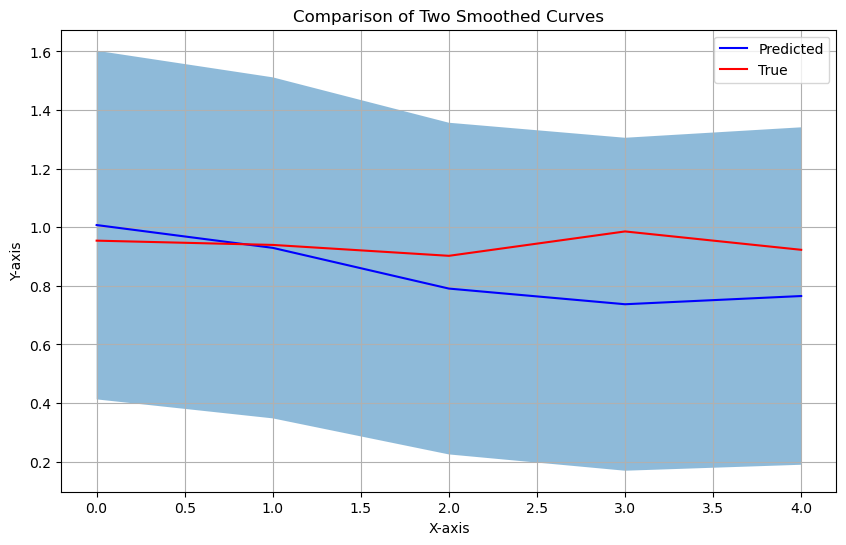

In [143]:

random_num = np.random.randint(0, len(X_test), size=1)[0]
print("Num "+str(random_num)+" Chosen for display")


X_test_rnd=X_test[random_num:random_num+1]
y_true=y_test[random_num:random_num+1]

mean, variance = m.predict_y(X_test_rnd)

X_plt_axis=np.arange(y_true.shape[1])
print(mean[0])
print(y_true)

plt.figure(figsize=(10, 6))
plt.plot(X_plt_axis, mean[0], label='Predicted', color='blue')
plt.plot(X_plt_axis, y_true[0], label='True', color='red')
plt.fill_between(X_plt_axis, mean[0]+ 2.0 * variance[0] ** 0.5, mean[0]- 2.0 * variance[0] ** 0.5, alpha=0.5)
# 添加标题和标签
plt.title('Comparison of Two Smoothed Curves')
plt.xlabel('X-axis')
# plt.ylim(-0.5, 1.5)
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)

